In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from scipy.stats import zscore
import scipy.io
from scipy.cluster.hierarchy import fcluster
import umap

from pydmd import DMD

import matplotlib.pyplot as plt
import seaborn as sns

2023-09-12 12:49:51.355051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 12:49:51.472579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-12 12:49:51.472605: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-12 12:49:51.499473: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-12 12:49:52.356662: W tensorflow/stream_executor/pla

In [2]:
fpath = f"/nfs/turbo/umms-indikar/shared/projects/myod/clean_data/time_series_rna_Z_scores.csv"

"""Load the Z-score data frame """
df = pd.read_csv(fpath, index_col=0)
print(f"{df.shape=}")
df.head()

df.shape=(48, 20967)


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
T0_R1,1.405404,1.354427,-0.350276,1.712226,-0.702826,-0.118115,-0.470459,1.108334,2.080126,0.176877,...,-0.550108,-0.502374,-0.971989,-0.494887,-1.431415,-0.642975,-2.125625,0.878478,-1.223717,-0.486207
T0_R2,1.039275,1.099166,0.086865,1.994941,-1.442005,1.298854,-0.470459,0.605171,0.948936,-0.060846,...,-0.648207,-0.549161,-0.830686,-0.571403,-0.355441,-0.649817,-1.159188,0.271296,0.179373,-0.310175
T0_R3,2.685915,1.322179,-0.840162,0.867014,-1.295536,0.041865,-0.470459,1.855671,2.331780,1.593111,...,-0.684741,-0.533209,-1.012156,-1.552568,-1.627332,-1.067803,-2.735546,1.435850,-1.810500,-1.022328
T1_R1,0.497787,1.699461,-0.979287,0.833893,0.598781,0.233814,-0.470459,0.042615,0.484603,-0.166841,...,0.038745,-0.135519,-0.922598,-1.298813,-0.747879,-1.036149,-0.334006,0.285189,-0.634321,-0.626263
T1_R2,1.506375,3.163352,0.129377,0.630835,-0.512408,0.441264,1.279210,-0.010344,1.225840,0.477273,...,0.031715,-0.181473,-1.030909,-0.676906,-0.935824,-0.723831,-0.332538,0.840669,-1.057363,-0.610950


In [3]:
def data2dmd(data):
    """A function to stack replicates for the dmd function below """
    print(f"input {data.shape=}")
    labels = pd.DataFrame(data.index, columns=['expId'])
    labels['time'] = labels['expId'].apply(lambda x: x.split("_")[0])
    labels['replicate'] = labels['expId'].apply(lambda x: x.split("_")[1])

    replicates = sorted(labels['replicate'].unique())

    dmd_data = []

    for r in replicates:
        # get the indices of the replicate
        ind = labels[labels['replicate'] == r]['expId'].to_list()

        t_data = data.loc[ind]
        dmd_data.append(t_data)
        print(r, t_data.shape)
        
    dmd_data = np.asarray(dmd_data)
    dmd_data = np.swapaxes(dmd_data, 0, 2)
    print(f"ouput {dmd_data.shape=}")

    return dmd_data

data = df.copy()
dmd_data = data2dmd(data)

input data.shape=(48, 20967)
R1 (16, 20967)
R2 (16, 20967)
R3 (16, 20967)
ouput dmd_data.shape=(20967, 16, 3)


array([[[ 1.40540372,  1.03927548,  2.68591495],
        [ 0.49778691,  1.50637461,  1.89067491],
        [ 1.1554993 ,  1.54527054,  1.49697927],
        ...,
        [-1.92657205, -1.33743596, -1.73592593],
        [ 0.29252002, -0.0237124 , -0.19375643],
        [-0.06583677, -1.03929827, -0.7119693 ]],

       [[ 1.35442711,  1.09916551,  1.32217921],
        [ 1.69946085,  3.16335242,  2.55182161],
        [-1.01380848, -0.65585743, -0.89494274],
        ...,
        [-0.98558022,  0.08822406, -0.24754215],
        [-1.05234406, -0.02016686,  0.16241308],
        [-0.75314547, -0.60516521, -1.57897376]],

       [[-0.35027577,  0.0868653 , -0.84016241],
        [-0.97928717,  0.12937677, -0.71063396],
        [-0.78006521, -0.03530376,  0.05433965],
        ...,
        [ 2.87024898,  2.24072781,  2.28417423],
        [-1.23242941, -1.23242941, -1.23242941],
        [-0.79632028, -0.50248761, -0.15651846]],

       ...,

       [[ 0.8784776 ,  0.271296  ,  1.43585011],
        [ 0

# Perform DMD

In [4]:
def n_step_prediction(A, X, ntimepts, nreps):
    X = X[:,:ntimepts].reshape(len(X),(ntimepts)*nreps,order='F')
    X_pred = np.zeros((A.shape[0],ntimepts*nreps))
    count = 0
    for i in range(0,nreps):
        x_test_ic = X[:,i*(ntimepts):i*(ntimepts)+1]
        for j in range(0,ntimepts):
            X_pred[:,count:count+1] = np.dot(np.linalg.matrix_power(A,j),x_test_ic) 
            count += 1
    feature_means = np.mean(X,axis=1).reshape(len(X),1)
    cd = 1 - ((np.linalg.norm(X - X_pred,ord=2)**2)/(np.linalg.norm(X - feature_means,ord=2)**2))   # coeff of determination aka R^2 
    if len(X) < 50: 
        print(f'r2_score for n-step prediction (reduced): {cd:.3e}')
    else: 
        print(f'r2_score for n-step prediction: {cd:.3e}')        
    return X_pred, cd


def getOHT(u, s, vh):
    # m = u.shape[0]
    # n = vh.shape[0] 

    # note, in our case, switched
    n = u.shape[0]
    m = vh.shape[0] 
    
    beta = m / n
    omega = (0.56*beta**3) - (0.95 * beta**2) + (1.82 * beta) + 1.43
    y_med = np.median(s)
    tau = omega * y_med
    s_ind = np.argwhere(s >= tau)
    oht = np.max(s_ind) 
    return oht
    

def dmd(data, rank_reduce=True, rank=None):
    """A function to compute the DMD of the data """

    """ RESHAPE DATA"""
    n, m, r = data.shape
    print(f"input {data.shape=} {n=} {m=} {r=}")
    Xp = data[:,:-1].reshape(n, (m-1)*r, order='F') 
    Xf = data[:,1:].reshape(n, (m-1)*r, order='F') 

    print(f"{Xp.shape=} {Xf.shape=}")

    """ SVD or EXTACT"""
    if rank_reduce:
        u, s, vh = np.linalg.svd(Xp)
        print(f"{u.shape=} {s.shape=} {vh.shape=}")
        
        if rank == None: 
            rank = getOHT(u, s, vh)
            print(f"OHT {rank=}")

        # perform DMD
        u_r = u[:, 0:rank] # truncate to rank-r
        s_r = s[0:rank]
        vh_r = vh[0:rank, :]
        Atilde = u_r.T @ Xf @ vh_r.T @ np.diag(1/s_r) # low-rank dynamics
        A = u_r@Atilde@u_r.T
    else:
        A = Xf @ np.linalg.pinv(Xp)  # full model A
        rank = np.minimum(Xp.shape[1], Xp.shape[0])

    print(f"{A.shape=}")
    
    """ PREDICTION ACCURACY """
    data_embedded = np.zeros((rank, m, r))
    print(f"{data_embedded.shape=}")

    for i in range(r):
        data_embedded[:,:,i] = np.dot(u_r.T, data[:,:,i])

    Xpred_embedded, cd = n_step_prediction(Atilde, data_embedded, m, r)

    """ DMD EIGENVALUES """
    L, W = np.linalg.eig(Atilde)
    print(f"{L.shape=} {W.shape=}")
    
    """ DMD MODES """
    Phi = Xf@vh_r.T@np.diag(1/s_r)@W
    print(f"{Phi.shape=}")

    """ DMD AMPLITUDES """
    amps = []
    for i in range(r):
        b_ri = np.linalg.inv(np.dot(W, np.diag(L))) @ data_embedded[:,:,i]
        amps.append(b_ri)
    
    return {
        'A' : A,
        'Atilde' : Atilde,
        'rank' : rank,
        'u_r' : u_r,
        'L' : L,
        'W' : W,
        'Phi' : Phi,
        'Xpred_embedded' : Xpred_embedded,
        'cd' : cd,
        'amplitudes' : amps
    }
    
rank = None # when None == optimal hard threshold  
rank_reduce = True # when false, this is exact DMD
dmd_res = dmd(dmd_data, rank_reduce=rank_reduce, rank=rank)
print(dmd_res.keys())
print('done')

input data.shape=(20967, 16, 3) n=20967 m=16 r=3
Xp.shape=(20967, 45) Xf.shape=(20967, 45)
u.shape=(20967, 20967) s.shape=(45,) vh.shape=(45, 45)
OHT rank=10
A.shape=(20967, 20967)
data_embedded.shape=(10, 16, 3)
r2_score for n-step prediction (reduced): 1.629e-01
L.shape=(10,) W.shape=(10, 10)
Phi.shape=(20967, 10)
dict_keys(['A', 'Atilde', 'rank', 'u_r', 'L', 'W', 'Phi', 'Xpred_embedded', 'cd', 'amplitudes'])
done


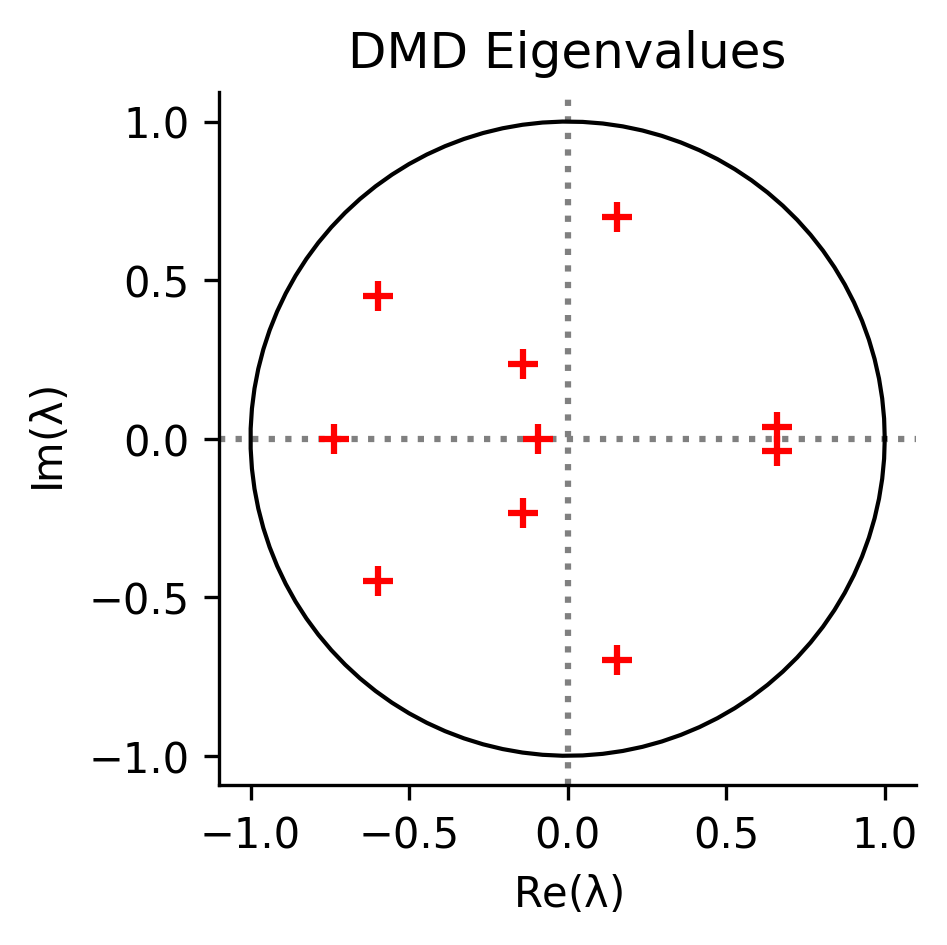

In [5]:
t = np.linspace(0, np.pi*2, 100)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

L = dmd_res['L']

# make the unit circle
plt.plot(np.cos(t), 
         np.sin(t), 
         linewidth=1, 
         c='k',
         zorder=1)

# plot the eigenvalues
plt.scatter(np.real(L), 
            np.imag(L),
            marker="+", 
            s=50,
            c='r',
            zorder=3)

# add the axis
plt.axvline(x=0, ls=":", c='grey', zorder=0)
plt.axhline(y=0, ls=":", c='grey', zorder=0)

plt.axis('equal')
plt.title("DMD Eigenvalues")
plt.xlabel(r'$\mathregular{Re(\lambda)}$')
plt.ylabel(r'$\mathregular{Im(\lambda)}$')

sns.despine()

In [6]:
# # cluster genes by modes
# phi = dmd_res['Phi']

# """UMAP embedding for plotting """
# n_neighbors = 11
# min_dist = 0.8
# mappy = umap.UMAP(n_components=2, 
#                   n_neighbors=n_neighbors,
#                   min_dist=min_dist)

# edf = mappy.fit_transform(np.real(phi))
# edf = pd.DataFrame(edf, columns=['UMAP1', 'UMAP2'])

# edf.head()

# sns.scatterplot(data=edf,
#                 x='UMAP1',
#                 y='UMAP2',
#                 ec='none')

In [7]:
# for replicate in dmd_res['amplitudes']:
#     print(f"{replicate.shape=}")

#     sns.lineplot(np.real(replicate))
#     # plt.imshow(np.real(replicate))
#     break

In [8]:
# break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
def gram_matrix(A, x0, nT=50, reduced=True, projection_matrix=np.array([])):
    '''
    A: matrix representation of the Koopman operator
    x0: initial conditions from measurements
    nT: number of timepoints over which to compute the Gram matrix
    reduced: if True, will compute reduced G from reduced data and KO and will also return full G after inverse projection
    projection_matrix: the matrix used to project data and KO to low-dimensional space (first r eigenvectors of Data.T @ Data)
    Both A and x0 can be either the full dimensional data and KO or they can be the DMD projected data and KO
    If projected, then return both the projected G and the full G after inverting the projection
    If not projected, then compute full G (can be slow, especially if the data dimension exceeds a couple thousand)
    Furthermore, for sensor placement we need to compute the eigendecomposition of G, so having the reduced G is handy   
    '''

    # generate artificial initial conditions for robust optimization 
    # get the min and max of each gene's initial value
    x0min = np.min(x0, axis=1)
    x0max = np.max(x0, axis=1)
    # form a set of new initial conditions distributed uniformly from x0min to x0max
    numICs = x0.shape[0]
    x0uni = np.zeros((len(x0min),numICs))
    x0uni[:,0:x0.shape[1]] = deepcopy(x0)
    for ii in range(x0.shape[1], x0uni.shape[1]):
        x0tmp = np.random.uniform(x0min,x0max)
        x0uni[:,ii] = x0tmp

    G = np.zeros_like(A)
    for ii in range(nT):
        print(f"{ii}...")
        A_pow = np.linalg.matrix_power(A,ii)
        G += np.matmul( np.matmul(A_pow, x0uni), np.matmul(x0uni.T, A_pow.T) ) 
    # right eigenvectors of G (columns of V) are rows of the gene sampling matrix (or vector if just one eigvec kept)

    if reduced: 
        Gfull = np.matmul(np.matmul(projection_matrix, G), projection_matrix.T)
        return G, Gfull
    else: 
        return G # this is the full G, computed directly from full KO and data


A = dmd_res['A']
nT = 8
G = gram_matrix(A, dmd_data[:,0,:], nT=nT, reduced=False)
print(f"{G.shape=}")

In [ ]:
# compute eigendecomposition of the Gram matrices
# right eigenvectors of G (columns of V) are rows of the gene sampling matrix 
D, V = scipy.linalg.eig(G,left=False, right=True)
print(f"{D.shape=}{ V.shape=}")

In [ ]:
break

In [ ]:
U_r = dmd_res['u_r']
Atilde = dmd_res['Atilde']
rank = dmd_res['rank']

n, m, r = dmd_data.shape

# create a prediction object
X0 = np.zeros((rank, m, r))
print(f"{X0.shape=}")

for i in range(r):
    X0[:,:,i] = np.dot(U_r.T, dmd_data[:,:,i])

# make the predicitions
X_pred_red, cd_red = n_step_prediction(Atilde, X0, m, r)
print(f"{cd_red=:.3f} {X_pred_red.shape=}")

In [ ]:
break

In [ ]:
""" Another way"""

In [ ]:
W

# Error Plots

In [ ]:
# reshape the input
replicate = 2 # zero-indexed!
time = 10

X0 = dmd_data[:, 0, replicate]
Xf = dmd_data[:, time-1, replicate]

print(f"{X0.shape=}")
print(f"{Xf.shape=}")

Ahat = np.linalg.matrix_power(Atilde, time)
AhatExp = U_r@Ahat@U_r.T
print(f"{Ahat.shape=} {AhatExp.shape=}")

rec = np.dot(AhatExp, X0)
print(f"{rec.shape=}")

err = np.linalg.norm(rec - Xf)
score, pval = scipy.stats.pearsonr(rec, Xf)
print(f"Error: {err=:.3f}, correlation: {score=:.3f} ({pval=:3f})")

# dmd_data.shape

# n, m, r = dmd_data.shape
# # print(f"input {dmd_data.shape=} {n=} {m=} {r=}")
# X0 = dmd_data[:,:-1].reshape(n,(m-1)*r, order='F') 
# print(f"{X0.shape=}")

In [ ]:
replicate = 2 # zero-indexed!
time = 15

X0 = dmd_data[:, 0, replicate]

res = []

for t in np.linspace(0, time, time+1):

    # the expression at this time
    Xf = dmd_data[:, time-1, replicate]

    # the transition matrix
    Ahat = np.linalg.matrix_power(Atilde, int(t))
    AhatExp = U_r@Ahat@U_r.T

    rec = np.dot(AhatExp, X0)

    err = np.linalg.norm(rec - Xf)
    score, pval = scipy.stats.pearsonr(rec, Xf)

    row = {
        'time' : t,
        'error' : err,
        'score' : score,
        'pval' : pval,
    }

    res.append(row)


res = pd.DataFrame(res)

sns.lineplot(data=res, 
            x='time',
            y='error')


res.head()

In [ ]:
break

In [ ]:
break

In [ ]:
break

In [ ]:
""" plot reconstruction error """

In [ ]:
""" Cluster genes based on the temporal modes """


In [ ]:
""" perform observability analysis """